# Implementation of Basic Machine Learning Algorithms on Ames Housing Dataset (Regression Task)

This notebook implements Linear Regression on the Ames Housing Dataset. The dataset has been provided by Kaggle. https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from LinearRegression import LinearRegression
%matplotlib inline

In [2]:
def plot_curve(Xlist, Ylist, title, xlabel, ylabel, plotlabels):
    plt.figure()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    cnt = 0
    for X in Xlist:
        Y = Ylist[cnt]
        label = plotlabels[cnt]
        plt.plot(X, Y, 'o-', label=label)
        cnt += 1
    plt.legend(loc="best")
    plt.show()
    plt.clf()

def load_dataset():
    train_initial = pd.read_csv('datasets/train.csv')
    test_initial = pd.read_csv('datasets/test.csv')
    return train_initial, test_initial

train_initial, test_initial = load_dataset()
print("initial train data size", train_initial.shape)

train_2 = train_initial.copy()

# ignore Id; ignore MasVnrArea and GarageYrBlt too for now as no easy way of handling missing values
train_2 = train_2.drop(['Id', 'MasVnrArea', 'GarageYrBlt'], axis=1)

# transform year variables to be, 'years since 2018'
train_2[['YearBuilt', 'YearRemodAdd', 'YrSold']] = 2018 - train_2[['YearBuilt', 'YearRemodAdd', 'YrSold']]

numeric_features = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
 'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold', 'SalePrice']

# get non-numeric columns
non_numeric_columns = np.setdiff1d(train_2.columns.values,numeric_features)

# create dummy variables for categorical variables
# TODO: ideally would want to create these based on a list of possible feature values,
# otherwise will have to combine with test data and then create dummy variables 
# as some feature values might be present in one set but not the other sample
train_2 = pd.get_dummies(train_2, columns=non_numeric_columns, drop_first=True, dummy_na=True)
print("updated training data size", train_2.shape)

# interaction variable for MiscVal based on type of MiscFeature
miscfeatures = [col for col in train_2.columns.values if col.startswith('MiscFeature')]

train_2[miscfeatures] = train_2[miscfeatures].multiply(train_2['MiscVal'],axis="index")

# replace missing values with mean. ideally we will want to do this separately in each training fold separately
# but here we are focusing on training only and not validation / leakage 
train_2 = train_2.fillna(train_2.mean())
train_X = train_2.drop(['SalePrice'], axis=1).values
train_y = train_2[['SalePrice']].values
# scaling y variable
train_y = train_y / 100000

initial train data size (1460, 81)
updated training data size (1460, 329)


## Gradient Descent
Below, we see the effect of varying learning rate on Gradient Descent Algorithm. As learning rate increases, the convergence is reached faster - i.e. at earlier iteration. However, if we increase learning rate too much, the cost function starts increasing instead of decreasing - i.e. Gradient descent does not work as expected.

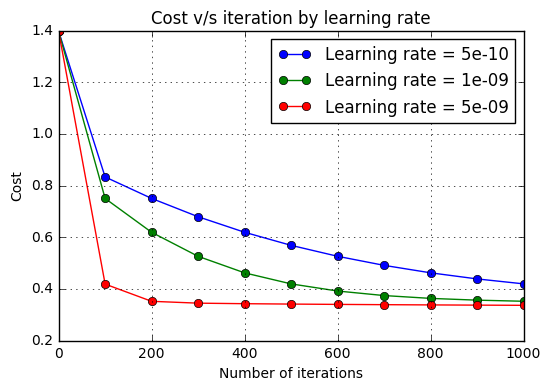

In [14]:
learning_rate = [0.0000000005, 0.000000001, 0.000000005]
max_iter = 1000
iteration_threshold = 100

cost_by_lr = np.empty((0,math.floor(max_iter/iteration_threshold)+1))
iterations = np.empty((0,math.floor(max_iter/iteration_threshold)+1))
plotlabels = []

for lr in learning_rate:
    estimator_linReg = LinearRegression(learning_rate=lr, reg_strength=0, regularization="Ridge", 
                                    max_iter=max_iter, iteration_threshold=iteration_threshold)
    estimator_linReg.fit(train_X, train_y)

    cost_by_lr = np.vstack((cost_by_lr, estimator_linReg.cost_by_iteration))
    iterations = np.vstack((iterations, estimator_linReg.iterations))
    plotlabels.append("Learning rate = " + str(lr))

plot_curve(Ylist=cost_by_lr, Xlist=iterations, title="Cost v/s iteration by learning rate", 
           xlabel="Number of iterations", ylabel="Cost", plotlabels=plotlabels)

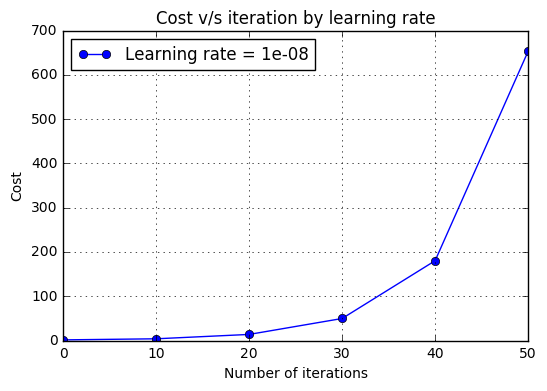

In [15]:
learning_rate = [0.00000001]
max_iter = 50
iteration_threshold = 10

cost_by_lr = np.empty((0,math.floor(max_iter/iteration_threshold)+1))
iterations = np.empty((0,math.floor(max_iter/iteration_threshold)+1))
plotlabels = []

for lr in learning_rate:
    estimator_linReg = LinearRegression(learning_rate=lr, reg_strength=0, regularization="Ridge", 
                                    max_iter=max_iter, iteration_threshold=iteration_threshold)
    estimator_linReg.fit(train_X, train_y)

    cost_by_lr = np.vstack((cost_by_lr, estimator_linReg.cost_by_iteration))
    iterations = np.vstack((iterations, estimator_linReg.iterations))
    plotlabels.append("Learning rate = "+str(lr))
    
plot_curve(Ylist=cost_by_lr, Xlist=iterations, title="Cost v/s iteration by learning rate", 
           xlabel="Number of iterations", ylabel="Cost", plotlabels=plotlabels)

## Stochastic Gradient Descent
Instead of looking at full data to compute the gradient, stochastic gradient descent (SGD) looks at a random training example. In many cases, based on the dataset size, it is not feasible to run the gradient descent. SGD often reaches the minima in fewer iterations over the dataset. Below, we see SGD in action.

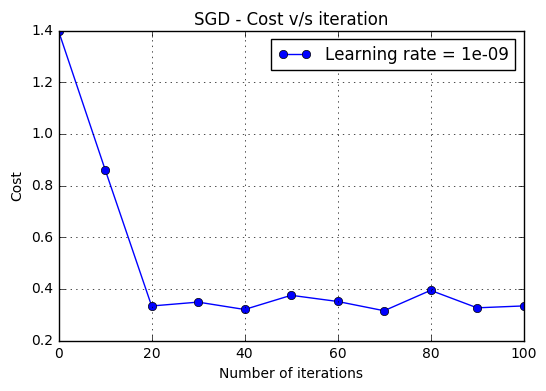

In [24]:
learning_rate = [0.0000000001]
max_iter = 100
iteration_threshold = 10

cost_by_lr = np.empty((0,math.floor(max_iter/iteration_threshold)+1))
iterations = np.empty((0,math.floor(max_iter/iteration_threshold)+1))
plotlabels = []

for lr in learning_rate:
    estimator_linReg = LinearRegression(learning_rate=lr, reg_strength=0, regularization="Ridge", 
                                    max_iter=max_iter, iteration_threshold=iteration_threshold, method="SGD")
    estimator_linReg.fit(train_X, train_y)

    cost_by_lr = np.vstack((cost_by_lr, estimator_linReg.cost_by_iteration))
    iterations = np.vstack((iterations, estimator_linReg.iterations))
    plotlabels.append("Learning rate = "+str(lr))
    #print("For learning_rate, " + str(lr) + ", time taken is " + str(estimator_linReg.training_time) + " seconds.")

plot_curve(Ylist=cost_by_lr, Xlist=iterations, title="SGD - Cost v/s iteration", 
           xlabel="Number of iterations", ylabel="Cost", plotlabels=plotlabels)

## Minibatch Gradient Descent
In the SGD graph above, we notice that how approximation of the gradient can lead to increase in cost sometimes. This is a trade-off between reaching minima faster but cost values not being smooth over iterations. To balance this trade-off, we can use Minibatch Gradient Descent which is a more general case for stochastic gradient descent - i.e. instead of taking 1 training example to compute gradient, we take 'b' examples. Higher the batch size, closer the results to gradient descent, and vice-versa for stochastic gradient descent. In the graph below, notice how with larger batch size, the cost curve is smoother.

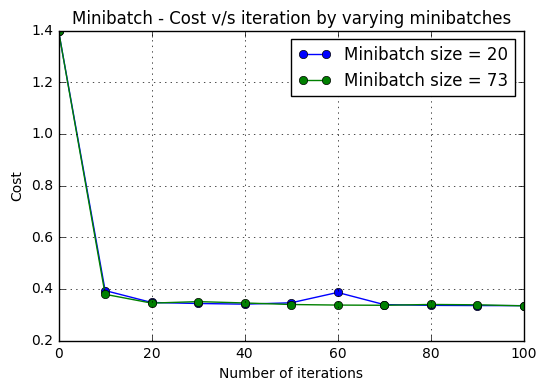

In [32]:
learning_rate = 0.0000000005
max_iter = 100
iteration_threshold = 10
minibatch_size = [20, 73]

cost_by_lr = np.empty((0,math.floor(max_iter/iteration_threshold)+1))
iterations = np.empty((0,math.floor(max_iter/iteration_threshold)+1))
plotlabels = []

for mb in minibatch_size:
    estimator_linReg = LinearRegression(learning_rate=lr, reg_strength=0, regularization="Ridge", 
                                    max_iter=max_iter, iteration_threshold=iteration_threshold, 
                                        method="Minibatch", minibatch_size=20)
    estimator_linReg.fit(train_X, train_y)

    cost_by_lr = np.vstack((cost_by_lr, estimator_linReg.cost_by_iteration))
    iterations = np.vstack((iterations, estimator_linReg.iterations))
    plotlabels.append("Minibatch size = "+str(mb))
    #print("For learning_rate, " + str(lr) + ", time taken is " + str(estimator_linReg.training_time) + " seconds.")

plot_curve(Ylist=cost_by_lr, Xlist=iterations, title="Minibatch - Cost v/s iteration by varying minibatches", 
           xlabel="Number of iterations", ylabel="Cost", plotlabels=plotlabels)

## Comparing various types of Gradient Descent
Here, we compare the three algorithms discussed above by looking at thee results in one graph. We can see that Gradient Descent shows a smooth descent of the cost value, but requires more iterations over the dataset. SGD reaches the minima in much less iterations but is very 'jumpy'. Finally, minibatch GD balances them by being faster than GD but less jumpy than SGD.

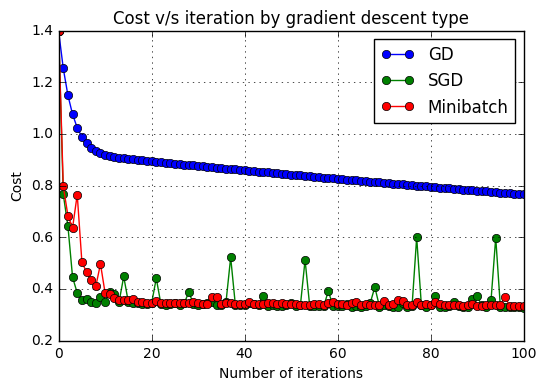

In [38]:
learning_rate = [0.0000000009, 0.0000000001, 0.0000000009]
max_iter = 100
iteration_threshold = 1

cost_by_lr = np.empty((0,math.floor(max_iter/iteration_threshold)+1))
iterations = np.empty((0,math.floor(max_iter/iteration_threshold)+1))
plotlabels = ['GD', 'SGD', 'Minibatch']
cnt = 0

for pl in plotlabels:
    estimator_linReg = LinearRegression(learning_rate=learning_rate[cnt], reg_strength=0, regularization="Ridge", 
                                    max_iter=max_iter, iteration_threshold=iteration_threshold, 
                                        method=pl, minibatch_size=20)
    estimator_linReg.fit(train_X, train_y)

    cost_by_lr = np.vstack((cost_by_lr, estimator_linReg.cost_by_iteration))
    iterations = np.vstack((iterations, estimator_linReg.iterations))
    #print("For algorithm - " + str(pl) + ", time taken is " + str(estimator_linReg.training_time) + " seconds.")
    cnt += 1

plot_curve(Ylist=cost_by_lr, Xlist=iterations, title="Cost v/s iteration by gradient descent type", 
           xlabel="Number of iterations", ylabel="Cost", plotlabels=plotlabels)